Основная задача - построить модель, предсказывающую вероятность выживания пассажира в зависимости от некоторого набора переменных

Для начала посмотрим на данные, с которыми предстоить работать

In [521]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

In [522]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [523]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [524]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Приведем названия столбцов в удобный вид

In [525]:
new_column_names = []
for column in df.columns:
    new_column_name = re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower()
    new_column_names.append(new_column_name)

df.columns = new_column_names
df.rename(columns={'parch': 'par_ch', 'pclass': 'class'}, inplace=True)
df.columns

Index(['passenger_id', 'survived', 'class', 'name', 'sex', 'age', 'sib_sp',
       'par_ch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [526]:
df.isna().sum()

passenger_id      0
survived          0
class             0
name              0
sex               0
age             177
sib_sp            0
par_ch            0
ticket            0
fare              0
cabin           687
embarked          2
dtype: int64

Есть пропуски в данных, но удалить их нельзя, слишком большая доля 

Сделаем простые визуализации, чтобы лучше понимать данные

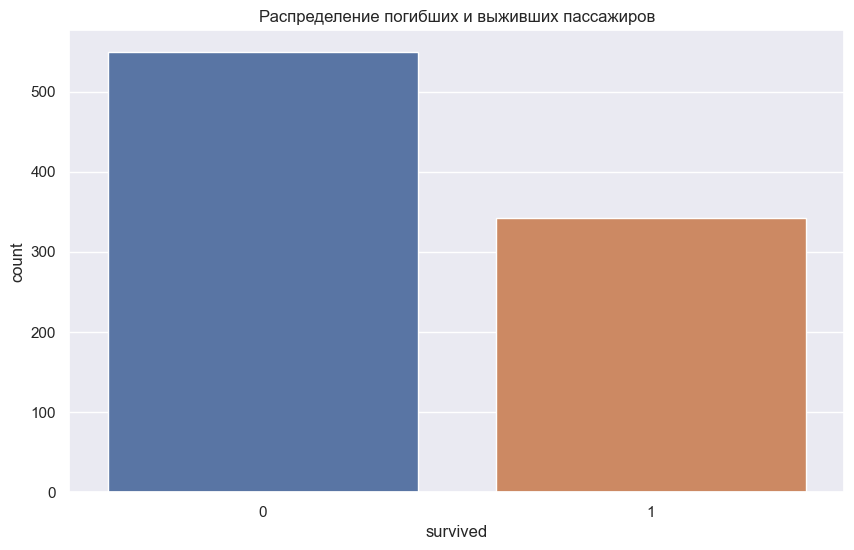

In [527]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='survived')
plt.title('Распределение погибших и выживших пассажиров')
plt.show()

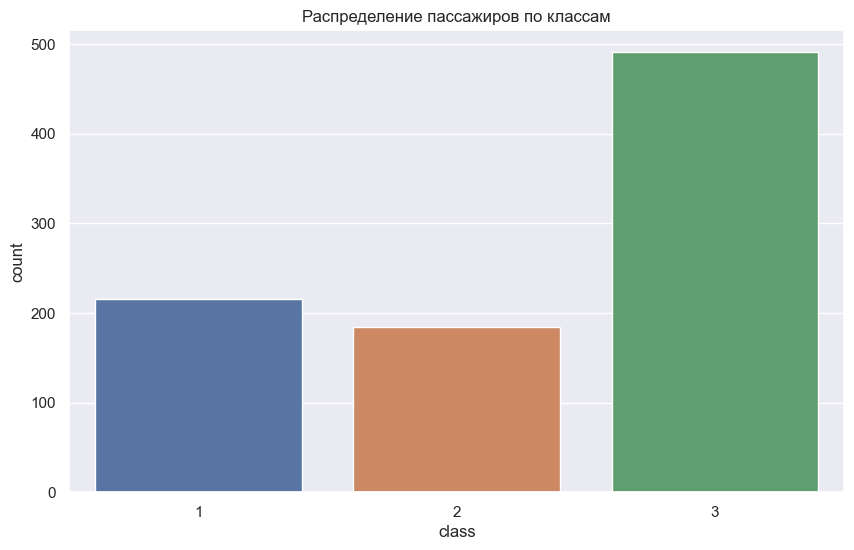

In [528]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='class')
plt.title('Распределение пассажиров по классам')
plt.show()

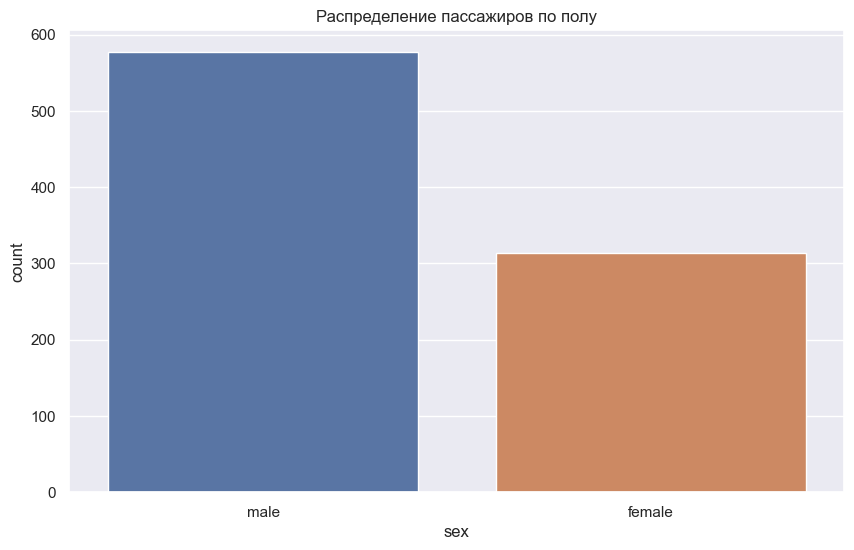

In [529]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='sex')
plt.title('Распределение пассажиров по полу')
plt.show()

Столбцы sib_sp - число братьев/сестер (siblings) или супругов (spouses) на борту; par_ch - число родителей (parents) и детей (children) на борту. 

Сложив значения, можно определить размер семьи пассажира

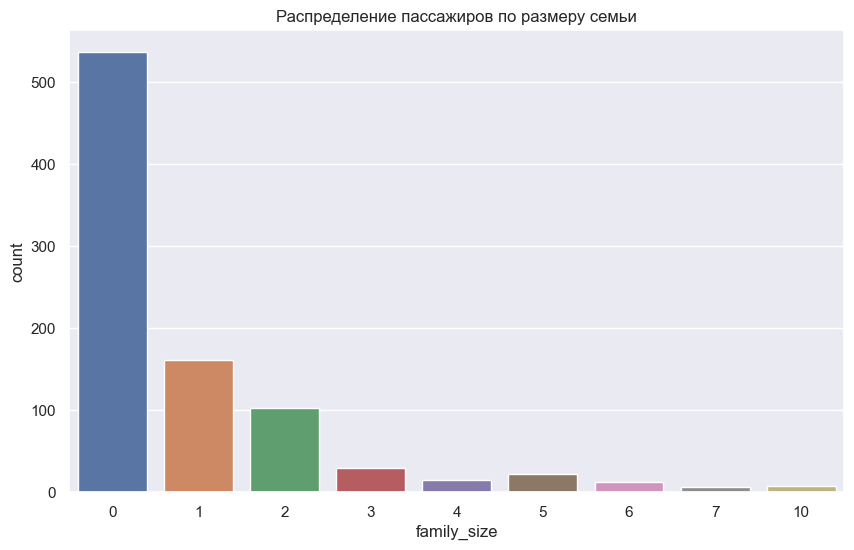

In [530]:
df['family_size'] = df['sib_sp'] + df['par_ch']
plt.figure(figsize=(10, 6))
sns.countplot(df, x='family_size')
plt.title('Распределение пассажиров по размеру семьи')
plt.show()

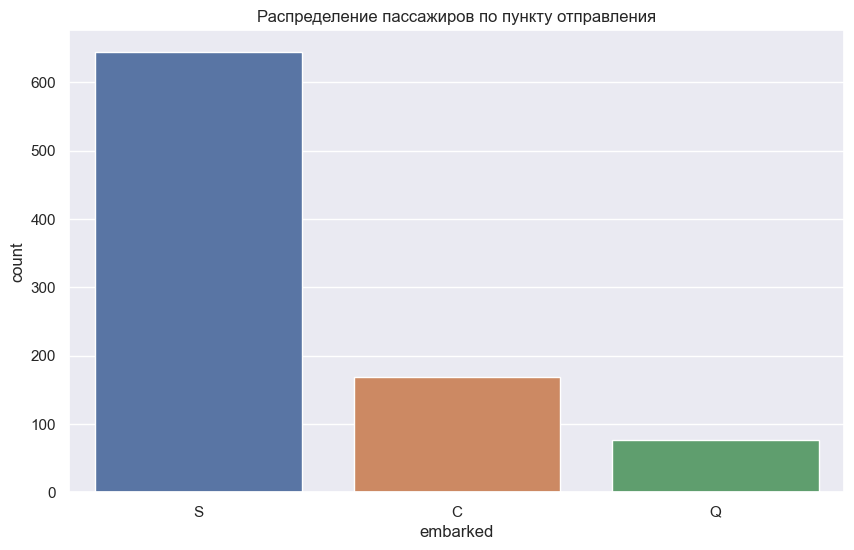

In [531]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='embarked')
plt.title('Распределение пассажиров по пункту отправления')
plt.show()

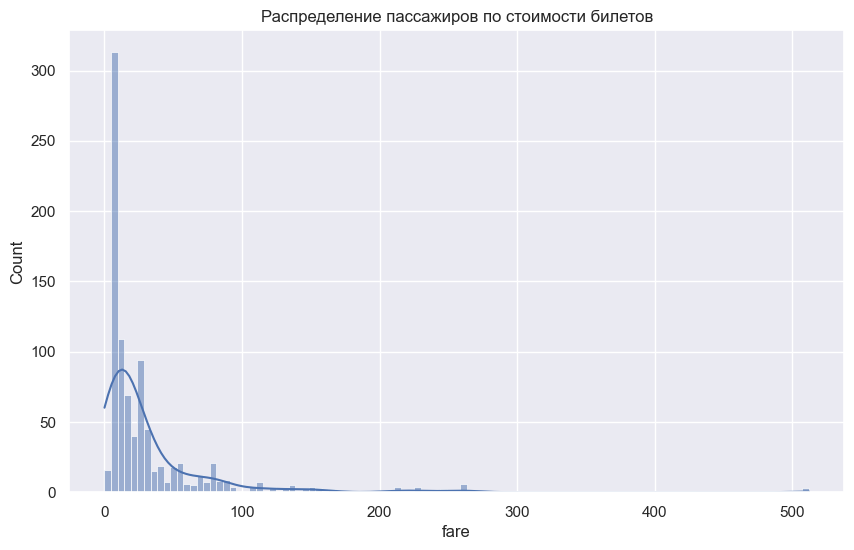

In [532]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x='fare', kde=True)
plt.title('Распределение пассажиров по стоимости билетов')
plt.show()

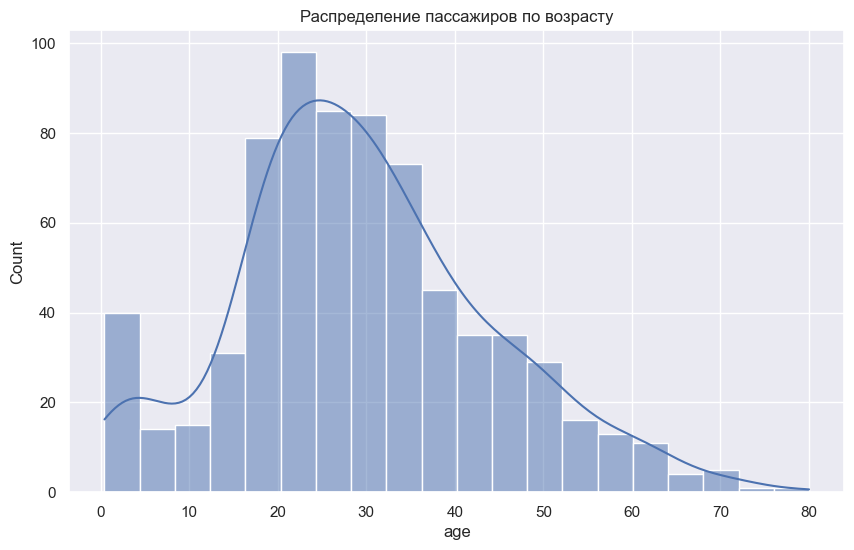

In [533]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x='age', kde=True)
plt.title('Распределение пассажиров по возрасту')
plt.show()

При поверхностном анализе выявили:

- число погибших пассажиров больше, чем выживших
- было больше пассажиров в каютах 3 класса с более дешевыми билетами
- на борту было больше мужчин, чем женщин
- было больше одиноких людей без семьи
- больше пассажиров сели на борт из пункта Southampton

Построим еще немного визуализаций, чтобы понять взаимоотношение между шансами выживания и другими факторами

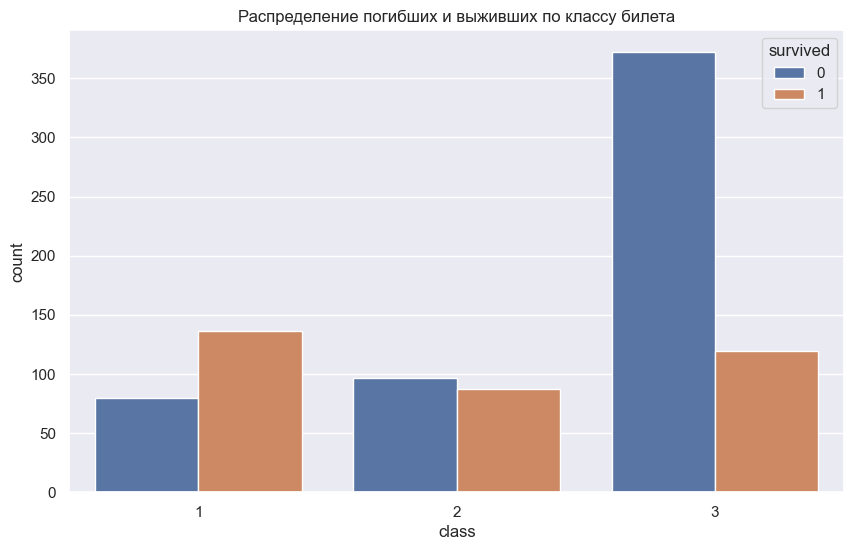

In [534]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='class', hue='survived')
plt.title('Распределение погибших и выживших по классу билета')
plt.show()

Чем выше класс билета - тем больше шансы выжить

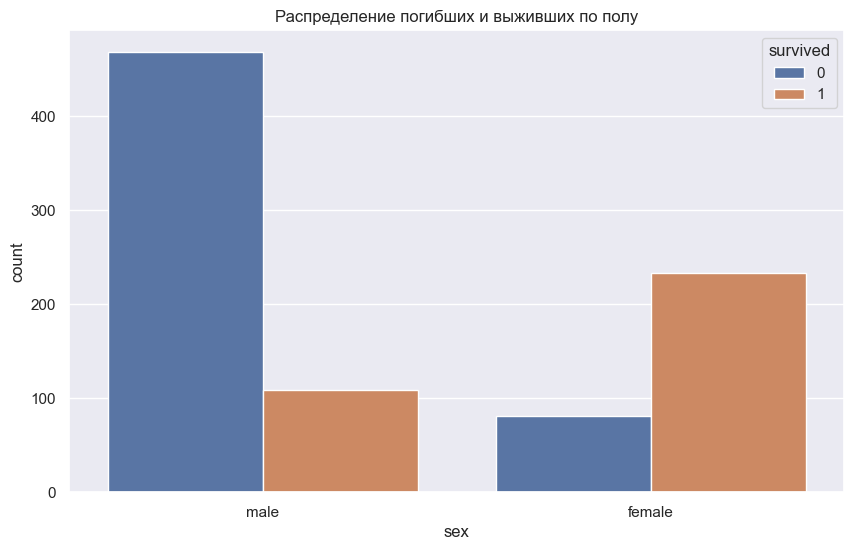

In [535]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='sex', hue='survived')
plt.title('Распределение погибших и выживших по полу')
plt.show()

У женщин шансы выжить больше

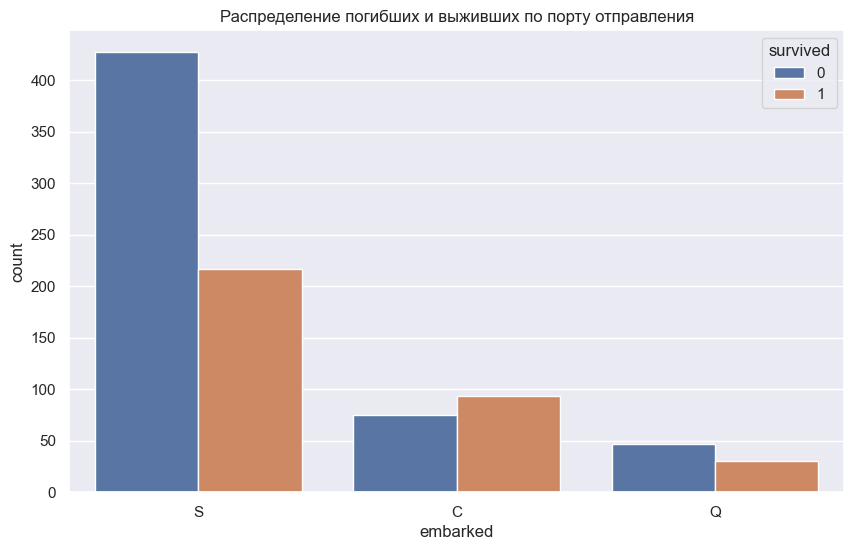

In [536]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='embarked', hue='survived')
plt.title('Распределение погибших и выживших по порту отправления')
plt.show()

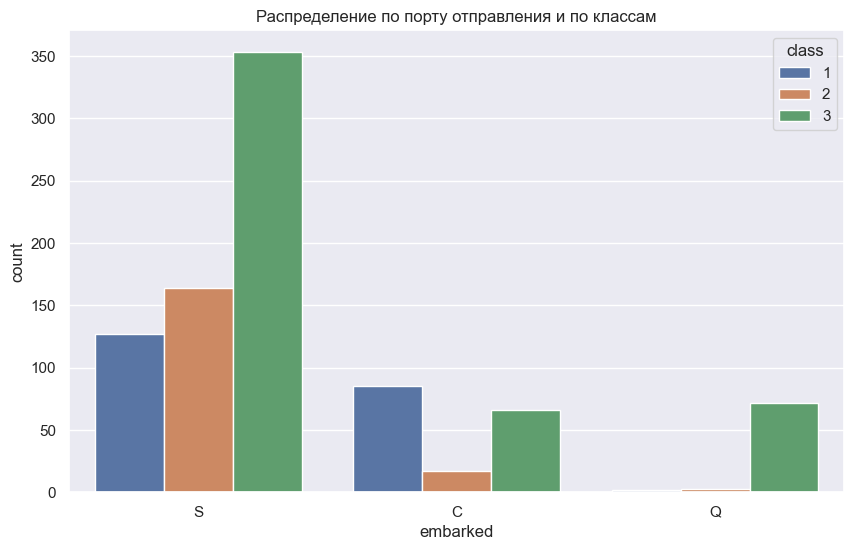

In [537]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='embarked', hue='class')
plt.title('Распределение по порту отправления и по классам')
plt.show()

Выживших по порту отправления в Southampton больше, но только потому что в принципе оттуда отправилось больше пассажиров 1 и 2 класса, чем из других портов

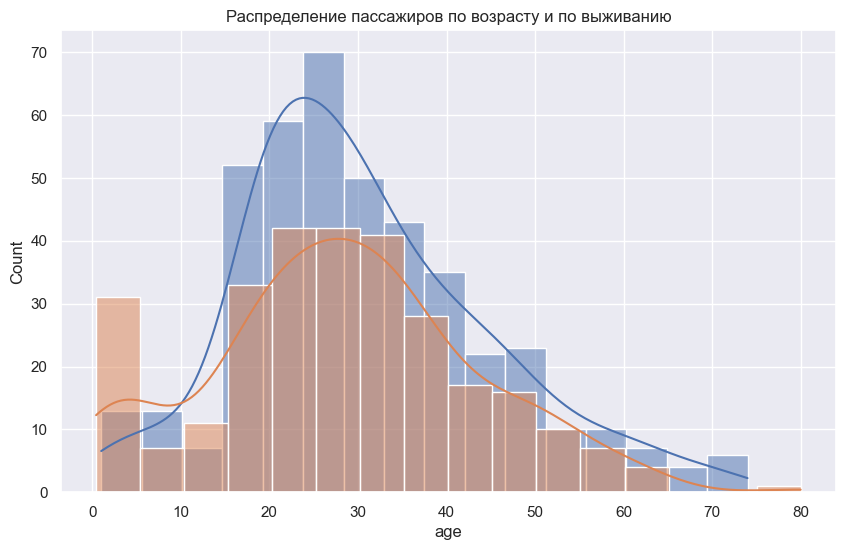

In [538]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['survived'] == 0], x='age', kde=True)
sns.histplot(data=df[df['survived'] == 1], x='age', kde=True)
plt.title('Распределение пассажиров по возрасту и по выживанию')
plt.show()

Распределения похожи, явной зависимости, что более молодые могли быстрее убежать, уплыть и пр. не прослеживается

Посмотрим на корреляцию между признаками

<AxesSubplot: >

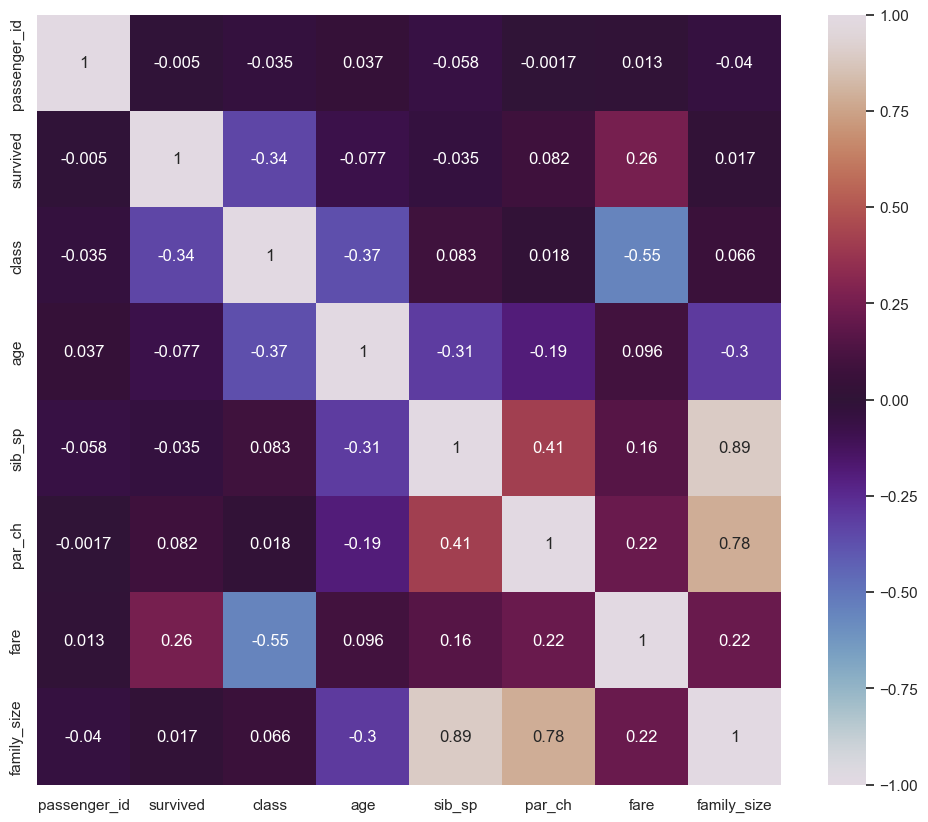

In [539]:
sns.set(rc = {'figure.figsize':(12,10)})
sns.heatmap(df.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'twilight')

Между возрастом и классом корреляция отрицательная - чем старше пассажир, тем он мог быть обеспеченнее и позволить себе каюту 1 класса. Ожидаемо, что есть связь между стоимостью билета (fare) и классом. 

Обработаем пропуски

In [540]:
df.cabin = df.cabin.fillna('unknown')
df.embarked = df.embarked.fillna('S') #всего 2 пропуска в embarked можно заменить на S, так как большинство пассажиров отправилось оттуда

В возрасте 177 пропусков (около 20% данных), заменить просто на среднее было бы не совсем точно.
Можно заметить, что в столбце Name имеется титул (Mr., Miss etc.)
Можно попробовать извлечь его и определить группу пассажиров. В каждой группе по титулу пассажирам без возраста можно проставить средний возраст группы по титулу

In [541]:
df['title'] = df['name'].str.split(',', expand=True)[1].str.extract('(\w+)')

In [542]:
df.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the', 'Jonkheer'],
      dtype=object)

In [543]:
df[df['title'] == 'the']['name'].item()

'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)'

In [544]:
df['title'].replace({'the': 'Countess'}, inplace=True)

In [545]:
df.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Среди пассажиров, у которых нет данных возраста, следующее распределение по титулам:

In [546]:
df[df['age'].isna()].groupby('title')['passenger_id'].count()

title
Dr          1
Master      4
Miss       36
Mr        119
Mrs        17
Name: passenger_id, dtype: int64

Заменим для каждой группы недостающие данные по возрасту средним по группе:

In [547]:
df.groupby('title')['age'].mean()

title
Capt        70.000000
Col         58.000000
Countess    33.000000
Don         40.000000
Dr          42.000000
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       4.574167
Miss        21.773973
Mlle        24.000000
Mme         24.000000
Mr          32.368090
Mrs         35.898148
Ms          28.000000
Rev         43.166667
Sir         49.000000
Name: age, dtype: float64

In [548]:
df2 = df.copy()
df2['group_age'] = df2.groupby('title')['age'].transform('mean')
df2.head()

,passenger_id,survived,class,name,sex,age,sib_sp,par_ch,ticket,fare,cabin,embarked,family_size,title,group_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknown,S,1,Mr,32.368090
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,35.898148
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknown,S,0,Miss,21.773973
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,35.898148
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknown,S,0,Mr,32.368090


In [549]:
df['age'].fillna(df2['group_age'], inplace=True)

Проверим, что не осталось пропусков

In [550]:
df.isna().sum()

passenger_id    0
survived        0
class           0
name            0
sex             0
age             0
sib_sp          0
par_ch          0
ticket          0
fare            0
cabin           0
embarked        0
family_size     0
title           0
dtype: int64

Титулов слишком много, некоторые из них можно объединить в группы

In [551]:
def group_titles(title):
    if title in ('Miss', 'Ms', 'Mlle'):
        return 'Miss'
    elif title in ('Mrs', 'Mme'):
        return 'Mrs'
    elif title == 'Mr':
        return 'Mr'
    elif title == 'Master':
        return 'Child'
    elif title in ('Capt', 'Col', 'Don', 'Major'):
        return 'Military'
    elif title in ('Countess', 'Jonkheer', 'Lady', 'Sir'):
        return 'Aristocrat'
    elif title in ('Dr', 'Rev'):
        return 'Other'
    
df['title_group'] = df['title'].apply(group_titles)


Посмотрим на выживаемость в зависимости от группы титула

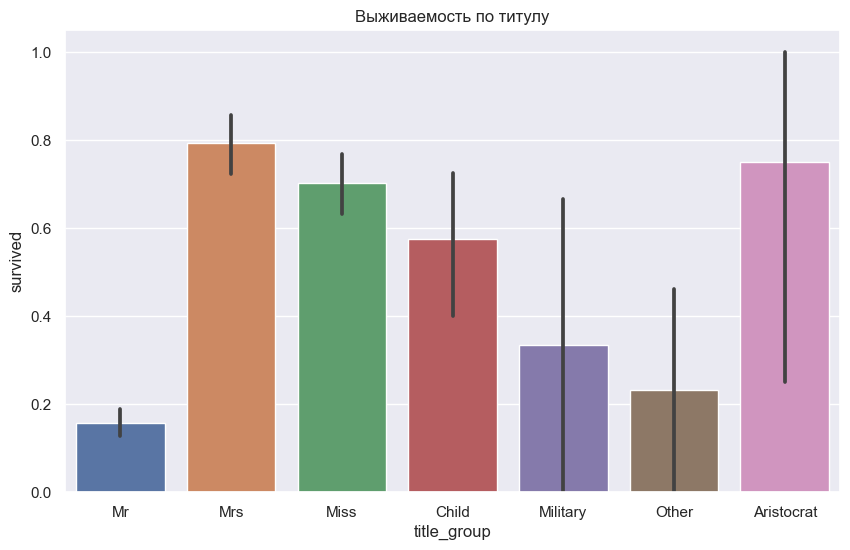

In [552]:
plt.figure(figsize=(10, 6))
sns.barplot(df, x='title_group', y='survived')
plt.title('Выживаемость по титулу')
plt.show()

Посмотрим на выживаемость еще по нескольким признакам

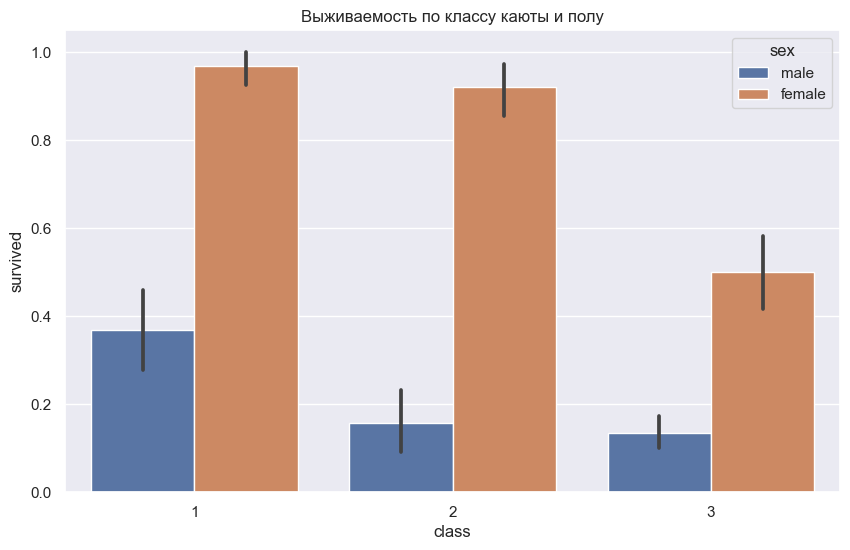

In [553]:
plt.figure(figsize=(10, 6))
sns.barplot(df, x='class', y='survived', hue='sex')
plt.title('Выживаемость по классу каюты и полу')
plt.show()

Основная группа выживших - женщины 1 и 2 класса

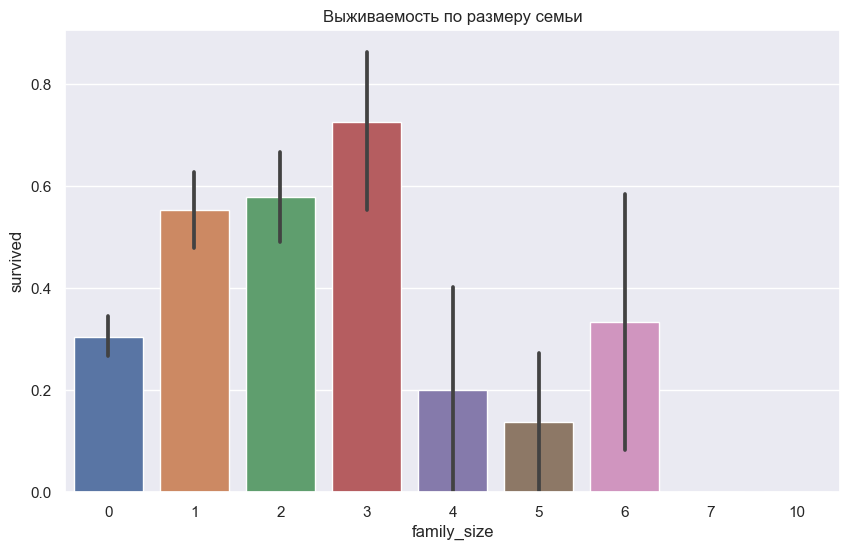

In [554]:
plt.figure(figsize=(10, 6))
sns.barplot(df, x='family_size', y='survived')
plt.title('Выживаемость по размеру семьи')
plt.show()

И слишком большая семья, и ее отсутствие отрицательно влияют на выживаемость

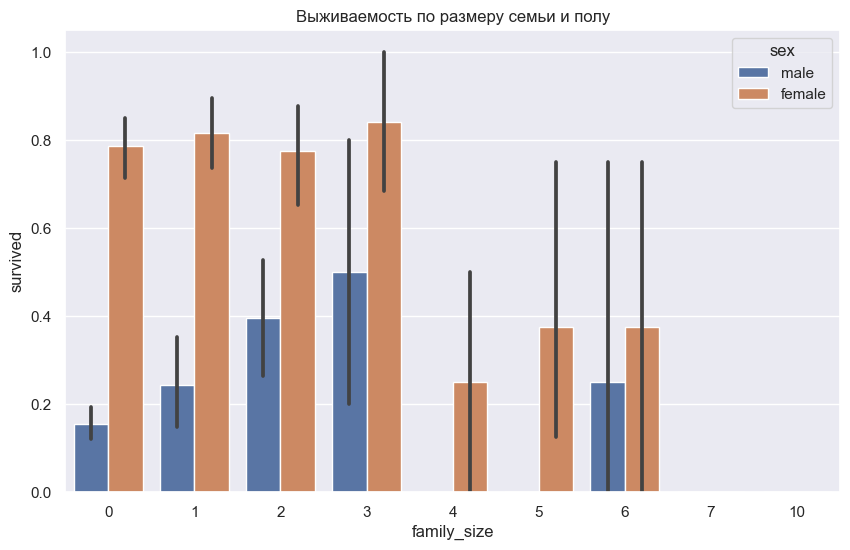

In [555]:
plt.figure(figsize=(10, 6))
sns.barplot(df, x='family_size', y='survived', hue='sex')
plt.title('Выживаемость по размеру семьи и полу')
plt.show()

Для женщин небольшой размер семьи повышает шансы выжить. Можно ввести признак hasFamily: 0 или 1 в зависимости от наличия родственников

In [556]:
df['hasFamily'] = df['family_size'].apply(lambda x: 0 if x == 0 else 1)

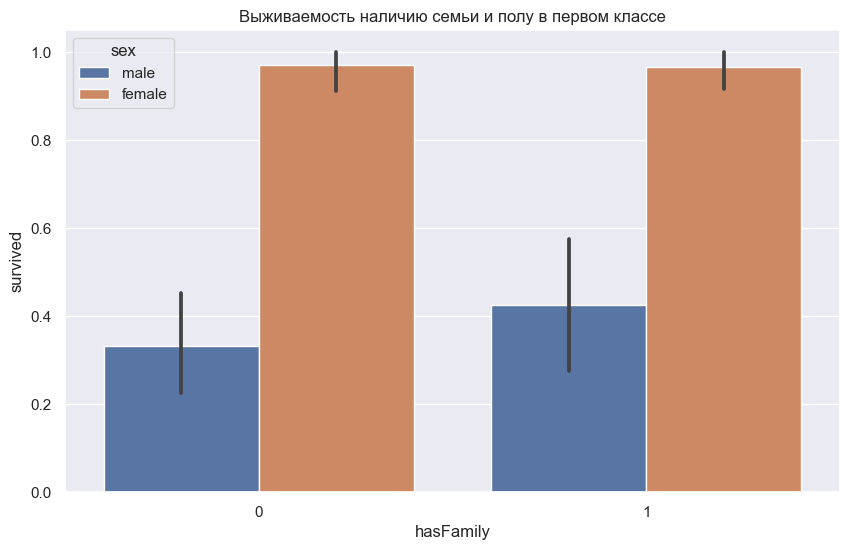

In [557]:
plt.figure(figsize=(10, 6))
sns.barplot(df[df['class'] == 1], x='hasFamily', y='survived', hue=df['sex'])
plt.title('Выживаемость наличию семьи и полу в первом классе')
plt.show()

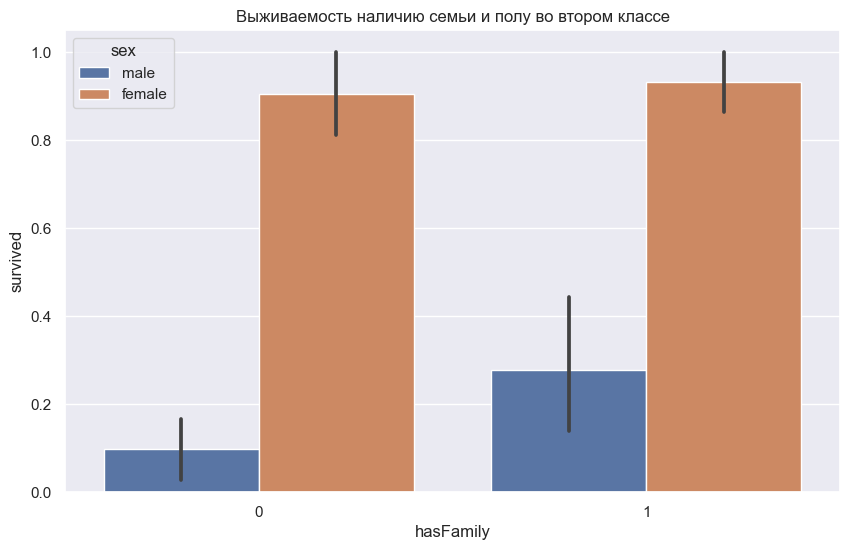

In [558]:
plt.figure(figsize=(10, 6))
sns.barplot(df[df['class'] == 2], x='hasFamily', y='survived', hue=df['sex'])
plt.title('Выживаемость наличию семьи и полу во втором классе')
plt.show()

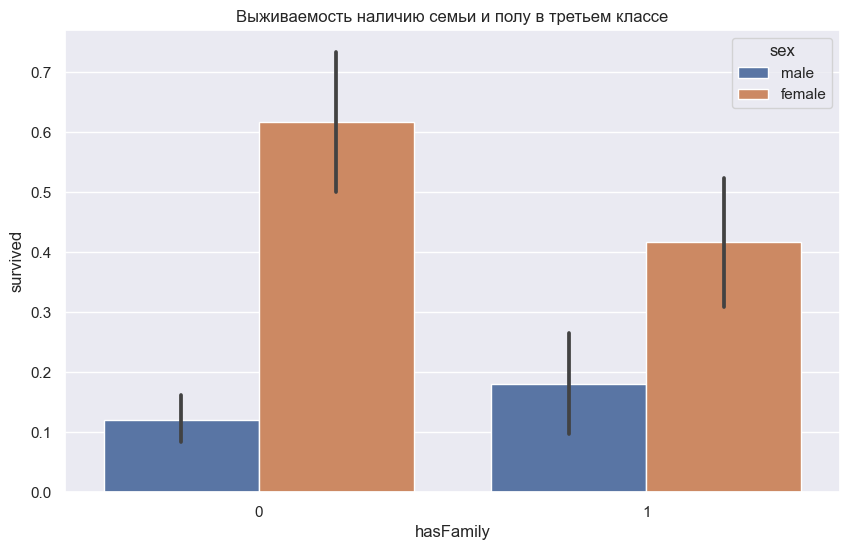

In [559]:
plt.figure(figsize=(10, 6))
sns.barplot(df[df['class'] == 3], x='hasFamily', y='survived', hue=df['sex'])
plt.title('Выживаемость наличию семьи и полу в третьем классе')
plt.show()

Если в первом и втором классе наличие семьи практически не влияет на выживаемость, то в третьем классе наличие семьи для женщин снижает шансы выжить. Для мужчин во всех классах наличие семьи повышает шансы выживания

В общем и целом, знания ML у меня пока очень поверхностные. Пока попробую построить модель, но еще вернусь к задаче, когда глубже погружусь в тему и научусь интерпретировать полученные результаты.
Пока что удалось провести разведывательный анализ данных, заполнить пропуски, построить визуализации и отобрать необходимые для модели признаки. 

In [560]:
df['sex'] = df['sex'].apply(lambda x: 0 if x == 'Male' else 1)

In [569]:
train = df[['survived', 'class', 'sex', 'age', 'fare', 'embarked', 'family_size', 'title_group', 'hasFamily']]

In [573]:
categorical_columns = ['class', 'embarked', 'title_group']
features_train = pd.get_dummies(train, columns=categorical_columns, drop_first=False)
features_train.drop(columns = 'survived', inplace=True)
features_train.columns

Index(['sex', 'age', 'fare', 'family_size', 'hasFamily', 'class_1', 'class_2',
       'class_3', 'embarked_C', 'embarked_Q', 'embarked_S',
       'title_group_Aristocrat', 'title_group_Child', 'title_group_Military',
       'title_group_Miss', 'title_group_Mr', 'title_group_Mrs',
       'title_group_Other'],
      dtype='object')

In [574]:
features_train.head()

,sex,age,fare,family_size,hasFamily,class_1,class_2,class_3,embarked_C,embarked_Q,embarked_S,title_group_Aristocrat,title_group_Child,title_group_Military,title_group_Miss,title_group_Mr,title_group_Mrs,title_group_Other
0,1,22.0,7.2500,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0
1,1,38.0,71.2833,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0
2,1,26.0,7.9250,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
3,1,35.0,53.1000,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0
4,1,35.0,8.0500,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0


In [592]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

In [577]:
X_train = features_train
y_train = train['survived']

In [578]:
X_train

,sex,age,fare,family_size,hasFamily,class_1,class_2,class_3,embarked_C,embarked_Q,embarked_S,title_group_Aristocrat,title_group_Child,title_group_Military,title_group_Miss,title_group_Mr,title_group_Mrs,title_group_Other
0,1,22.000000,7.2500,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0
1,1,38.000000,71.2833,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0
2,1,26.000000,7.9250,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
3,1,35.000000,53.1000,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0
4,1,35.000000,8.0500,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,27.000000,13.0000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
887,1,19.000000,30.0000,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
888,1,21.773973,23.4500,3,1,0,0,1,0,0,1,0,0,0,1,0,0,0
889,1,26.000000,30.0000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


In [579]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 891, dtype: int64

In [580]:
lr = LogisticRegression(solver="liblinear")
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)

In [582]:
print(f'Train ROC-AUC: {roc_auc_score(y_train, y_train_pred)}')

Train ROC-AUC: 0.8176349343303614


In [585]:
# подсчёт правильных ответов accuracy_score
acc_sc = accuracy_score(y_train, y_train_pred)
print('accuracy_score: ', acc_sc)

accuracy_score:  0.8316498316498316


In [587]:
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

[[482  67]
 [ 83 259]]


True Negative (TN) - случаи, когда мы правильно классифицировали объект как объект класса 0: 482

False Positive (FP) - случаи, когда мы классифицировали объект как объект класса 1, хотя, он на самом деле имеет класс 0: 67

False Negative (FN) - классифицировали объект как объект класса 0, а на самом деле он имеет класс 1: 83

True Positive (TP) - правильно классифицировали объект как объект класса 1: 259

In [591]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]


# Метрика precision (точность) является долей объектов класса 1, верно классифицированных моделью, к общему числу объектов, которые модель классифицировала как объекты класса 1
precision = TP / (TP + FP)
print(precision)
precision_score(y_train, y_train_pred)

0.7944785276073619


0.7944785276073619

In [593]:
#  Метрика recall (полнота) является долей найденных моделью объектов класса 1
recall = TP / (TP + FN)
print(recall)
recall_score(y_train, y_train_pred)

0.7573099415204678


0.7573099415204678

In [595]:
f1 = 2 * precision * recall / (precision + recall)
f1
print(f1)
f1_score(y_train, y_train_pred)

0.7754491017964072


0.7754491017964072

In [598]:
pd.DataFrame(y_train)['survived'].value_counts()

0    549
1    342
Name: survived, dtype: int64

In [599]:
pd.DataFrame(y_train_pred)[0].value_counts()

0    565
1    326
Name: 0, dtype: int64

In [600]:
scaler = StandardScaler()

In [601]:
X_train_scaled = scaler.fit_transform(X_train)

In [602]:
feature_names = X_train.columns
feature_names

Index(['sex', 'age', 'fare', 'family_size', 'hasFamily', 'class_1', 'class_2',
       'class_3', 'embarked_C', 'embarked_Q', 'embarked_S',
       'title_group_Aristocrat', 'title_group_Child', 'title_group_Military',
       'title_group_Miss', 'title_group_Mr', 'title_group_Mrs',
       'title_group_Other'],
      dtype='object')

In [604]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
X_train_scaled.head(3)

,sex,age,fare,family_size,hasFamily,class_1,class_2,class_3,embarked_C,embarked_Q,embarked_S,title_group_Aristocrat,title_group_Child,title_group_Military,title_group_Miss,title_group_Mr,title_group_Mrs,title_group_Other
0,0.0,-0.584387,-0.502445,0.059160,1.231645,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.067153,-0.216803,-0.082339,-0.511898,0.850532,-0.405840,-0.121681
1,0.0,0.621365,0.786845,0.059160,1.231645,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.623803,-0.067153,-0.216803,-0.082339,-0.511898,-1.175735,2.464027,-0.121681
2,0.0,-0.282949,-0.488854,-0.560975,-0.811922,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838,-0.067153,-0.216803,-0.082339,1.953514,-1.175735,-0.405840,-0.121681


In [605]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(solver='liblinear')

In [606]:
y_train_pred_scaled = lr.predict(X_train_scaled)

In [607]:
f1_score(y_train, y_train_pred_scaled)

0.7771084337349397